In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax
from keras.objectives import binary_crossentropy as bce

batch_size = 100
data_dim = 784
M = 10
N = 30
nb_epoch = 10
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

tau = K.variable(5.0, name="temperature")
x = Input(batch_shape=(batch_size, data_dim))
h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
logits_y = Dense(M*N)(h)

def sampling(logits_y):
    U = K.random_uniform(K.shape(logits_y), 0, 1)
    y = logits_y - K.log(-K.log(U + 1e-20) + 1e-20) # logits + gumbel noise
    y = softmax(K.reshape(y, (-1, N, M)) / tau)
    y = K.reshape(y, (-1, N*M))
    return y

z = Lambda(sampling, output_shape=(M*N,))(logits_y)
generator = Sequential()
generator.add(Dense(256, activation='relu', input_shape=(N*M, )))
generator.add(Dense(512, activation='relu'))
generator.add(Dense(data_dim, activation='sigmoid'))
x_hat = generator(z)

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))
def gumbel_loss(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    elbo = data_dim * bce(x, x_hat) - KL 
    return elbo

vae = Model(x, x_hat)
vae.compile(optimizer='adam', loss=gumbel_loss)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

for e in range(nb_epoch):
    vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
    K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * e), min_temperature]))

Using Theano backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 105.7564 - val_loss: 59.7007
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 44.9915 - val_loss: 33.3453
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 27.7229 - val_loss: 21.8194
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 46s - loss: 19.4595 - val_loss: 15.3097
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 49s - loss: 14.0679 - val_loss: 11.1422
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 50s - loss: 10.4756 - val_loss: 8.3099
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 43s - loss:

# Visualize results

In [3]:
argmax_y = K.max(K.reshape(logits_y, (-1, N, M)), axis=-1, keepdims=True)
argmax_y = K.equal(K.reshape(logits_y, (-1, N, M)), argmax_y)
encoder = K.function([x], [argmax_y, x_hat])

(<matplotlib.image.AxesImage at 0x11291c810>, (-0.5, 27.5, 27.5, -0.5))

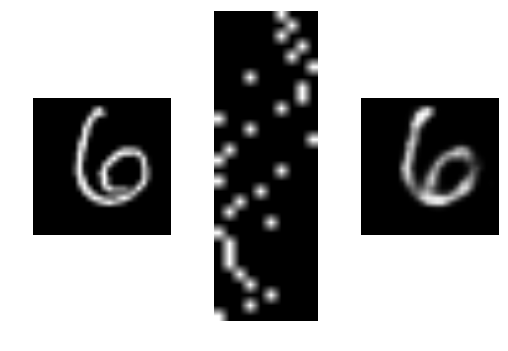

In [5]:
code, x_hat_test = encoder([x_test[100:200]])
subplot(131)
imshow(x_test[100:101].reshape(28, 28), cmap='gray'), axis('off')
subplot(132)
imshow(code[:1].reshape(N, M), cmap='gray'), axis('off')
subplot(133)
imshow(x_hat_test[:1].reshape(28, 28), cmap='gray'), axis('off')